In [1]:
import numpy as np
import pandas as pd

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import json

from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

from sklearn.decomposition import PCA

In [2]:
import sys
sys.path.append('../')
import util

In [3]:
STRAWBERRY = 'Strawberry'
TOMATO = 'Tomato'
MOLECULE = 'Molecule'

DATASET = MOLECULE

In [4]:
if DATASET == STRAWBERRY:
    TRAIN_FILE = '../data/strawberry_val_dataset.csv'
    VAL_FILE = '../data/strawberry_val_dataset.csv'
elif DATASET == TOMATO:
    TRAIN_FILE = '../data/tomato_val_dataset.csv'
    VAL_FILE = '../data/tomato_val_dataset.csv'
elif DATASET == MOLECULE:
    TRAIN_FILE = '../data/arc_final_des_w_odourless.csv'
    VAL_FILE = '../data/arc_final_des_w_odourless.csv'

data = pd.read_csv(TRAIN_FILE, index_col=0)
val_data = pd.read_csv(VAL_FILE, index_col=0)

data

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
107,0,0,0,0,0,1,1,0,0,0,...,0.079544,-0.309583,0.229812,-0.225654,-0.184476,-0.276874,-0.078284,-0.289294,-0.156600,-0.262982
126,0,0,0,0,1,0,1,0,0,0,...,0.441313,-0.366426,0.114024,-0.208623,-0.164807,-0.276874,-0.078540,-0.308622,-0.911674,-0.279963
174,0,0,0,0,0,0,0,1,0,0,...,-0.264947,-0.518598,-3.212648,-0.240023,-0.201070,-0.276874,-0.078785,-0.463240,-1.850547,-0.343642
176,0,0,0,0,0,0,0,0,0,0,...,2.805383,0.468025,1.369945,0.981963,1.151232,-0.071876,-0.066533,-0.207935,-0.193368,0.274244
177,0,0,0,0,0,1,0,0,0,0,...,-0.233591,-0.546488,-4.355704,-0.462953,-0.458533,-0.276874,-0.078803,-0.482568,-1.312753,-0.352132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141266555,0,1,1,0,0,0,0,0,0,0,...,-0.636741,-0.186708,-0.816137,-0.163149,-0.112288,-0.276874,-0.077239,-0.154003,0.465595,-0.224775
142523980,1,0,0,0,1,0,1,0,0,0,...,-0.713012,-0.254268,0.191796,-0.442738,-0.435186,-0.276874,-0.077960,-0.192658,0.272729,-0.241756
144116082,1,0,0,1,1,0,0,0,0,0,...,-0.645464,-0.231743,-0.191821,-0.439364,-0.431290,-0.276874,-0.077881,-0.076693,0.013597,-0.220530
145793235,1,1,0,0,0,0,0,0,0,0,...,-0.581379,-0.213136,-0.786994,-0.444615,-0.437354,-0.276874,-0.077355,-0.211985,0.248664,-0.237511


In [5]:
if len(data) % 2:
    data = data.drop(data.index[-1])
    val_data = val_data.drop(val_data.index[-1])

if DATASET == STRAWBERRY:
    OVERALL_LIKING = 'OVERALL LIKING'
elif DATASET == TOMATO:
    OVERALL_LIKING = 'Overall Liking'
elif DATASET == MOLECULE:
    OVERALL_LIKING = None


if DATASET == STRAWBERRY:
    NUM_LABEL_COLS = 5
elif DATASET == TOMATO:
    NUM_LABEL_COLS = 7
elif DATASET == MOLECULE:
    NUM_LABEL_COLS = 12


FEATURE_COLS = data.columns[NUM_LABEL_COLS:]
if DATASET == STRAWBERRY:
    LABEL_COLS = data.columns[[0]]
elif DATASET == TOMATO:
    LABEL_COLS = data.columns[[0]]
elif DATASET == MOLECULE:
    LABEL_COLS = data.columns[:NUM_LABEL_COLS]
print(FEATURE_COLS)
print(LABEL_COLS)

train_X = data[FEATURE_COLS].values
train_y = data[LABEL_COLS].values
val_X = val_data[FEATURE_COLS].values
val_y = val_data[LABEL_COLS].values

train_X.shape, train_y.shape, val_X.shape, val_y.shape

Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
       'nAtom', 'nHeavyAtom', 'nH',
       ...
       'AMW', 'WTPT-1', 'WTPT-2', 'WTPT-3', 'WTPT-4', 'WTPT-5', 'WPATH',
       'WPOL', 'XLogP', 'Zagreb'],
      dtype='object', length=1120)
Index(['Floral', 'Fruity', 'Herbal', 'Green', 'Woody', 'Sweet', 'Balsamic',
       'Earth', 'Spicy', 'Chemical', 'Animalic', 'Nutty'],
      dtype='object')


((2566, 1120), (2566, 12), (2566, 1120), (2566, 12))

In [6]:
train_X.min()

-40.56058088822893

In [7]:
# FOLDS = 2
# NUM_SAMPLE_TYPES = len(val_data)
# NUM_SAMPLES_PER_TYPE = len(data) // NUM_SAMPLE_TYPES

# fold_nums = list(range(FOLDS))
# [num*NUM_SAMPLE_TYPES for num in fold_nums]
# [(num+1)*NUM_SAMPLE_TYPES for num in fold_nums]

# val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)
indices = np.arange(train_X.shape[0])
# train_indices = np.array([indices[:indices.shape[0]//2], indices[indices.shape[0]//2:]])
# val_indices = np.array([indices[indices.shape[0]//2:], indices[:indices.shape[0]//2]])

FOLDS = 2
split_size = indices.shape[0]//FOLDS
train_indices = np.array([indices[:-split_size], indices[split_size:]])
val_indices = np.array([indices[-split_size:], indices[:split_size]])
train_indices
# print(FOLD_INDICES)

array([[   0,    1,    2, ..., 1280, 1281, 1282],
       [1283, 1284, 1285, ..., 2563, 2564, 2565]])

In [8]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h1> Hyperbolic </h1>

In [9]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_sizes, manifold):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = hnn.HLinear(input_size, layer_sizes[0], manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = []
        if len(layer_sizes) > 1:
            self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_sizes[i], layer_sizes[i+1], manifold=manifold) for i in range(len(layer_sizes)-1)])
        self.fc_out = hnn.HLinear(layer_sizes[-1], output_size, manifold=manifold)

    def forward(self, x):
        x = self.fc_in(x)
        emb = x
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            emb = x
            x = self.relu(x)
        x = self.fc_out(x)

        if self.training:
            return x, emb.detach().tensor

        return x


# Define training function
def hyp_train_model(model, train_loader, criterion, optimizer, manifold, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        outputs, emb = model(manifold_inputs)

        loss = criterion(outputs.tensor, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    # return running_loss / len(train_loader.dataset)
    return emb

<h1> EUCLIDEAN </h1>

In [10]:
# Define your MLP model
class EUC_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_sizes):
        super(EUC_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = nn.Linear(input_size, layer_sizes[0])
        self.relu = nn.ReLU()
        self.hidden_fcs = []
        if len(layer_sizes) > 1:
            self.hidden_fcs = nn.ModuleList([nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])
        self.fc_out = nn.Linear(layer_sizes[-1], output_size)


    def forward(self, x):
        x = self.fc_in(x)
        emb = x
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            emb = x
            x = self.relu(x)

        x = self.fc_out(x)

        if self.training:
            return x, emb.detach()

        return x

# Define training function
def euc_train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, emb = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    # return running_loss / len(train_loader.dataset)
    return emb

In [11]:
param_grid = {
    'model_type': ['hyp', 'euc'],
    # 'layer_sizes': [[64,2]],
    'layer_sizes': [[2]],
    'lr': [0.01],
    'weight_decay': [0.005],
    'batch_size': [2048],
    'epochs': [100],
    'curvature': [-1]
}

param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

2

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    model_type, layer_sizes, lr, weight_decay, batch_size, epochs, curvature = params

    for fold, (fold_train_indices, fold_val_indices) in enumerate(zip(train_indices, val_indices)):
        print(f'Fold {fold}')

        fold_train_X = train_X[fold_train_indices]
        fold_train_y = train_y[fold_train_indices]
        # fold_val_X   = val_X[fold_val_indices]
        # fold_val_y   = val_y[fold_val_indices]
        fold_val_X   = train_X[fold_val_indices]
        fold_val_y   = train_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        if model_type == 'hyp':
            manifold = PoincareBall(c=Curvature(curvature))
        elif model_type == 'euc':
            manifold = None

        if model_type == 'hyp':
            model = HYP_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_sizes=layer_sizes,
                            manifold=manifold).to(device)
        elif model_type == 'euc':
            model = EUC_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_sizes=layer_sizes).to(device)

        criterion = nn.MSELoss()

        if model_type == 'hyp':
            optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif model_type == 'euc':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'emb': {'train': [], 'val': []}, 'mae': {'train': [], 'val': []}}

        for epoch in range(epochs):
            if model_type == 'hyp':
                eval_stats['emb']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))

                eval_stats['mae']['val'].append(util.h_evaluate_mae(model, val_loader, manifold, device))
            elif model_type == 'euc':
                eval_stats['emb']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))

                eval_stats['mae']['val'].append(util.evaluate_mae(model, val_loader, device))

        model.train()
        input = torch.Tensor(fold_train_X)
        if model_type == 'hyp':
            tangents = TangentTensor(data=input, man_dim=-1, manifold=manifold)
            input = manifold.expmap(tangents)

        outputs, emb = model(input)
        eval_stats['emb']['train'].append(emb)


        print(eval_stats['mae']['val'])
        param_eval_stats.append(eval_stats)

----- Combination 0 -----
('model_type', 'hyp') ('layer_sizes', [2]) ('lr', 0.01) ('weight_decay', 0.005) ('batch_size', 2048) ('epochs', 100) ('curvature', -1)
Fold 0
[0.20337604, 0.19093688, 0.18267874, 0.17803712, 0.17599978, 0.1755135, 0.17629749, 0.17790496, 0.18004628, 0.18246217, 0.18492252, 0.1871385, 0.18917598, 0.19103682, 0.1927021, 0.19411774, 0.19537987, 0.19652766, 0.1975895, 0.19848502, 0.19916059, 0.19978774, 0.2003386, 0.20087826, 0.20152612, 0.20225835, 0.20317964, 0.20433854, 0.20586117, 0.20728254, 0.20862578, 0.20985915, 0.21090601, 0.21173728, 0.21234155, 0.21266119, 0.2126679, 0.21251017, 0.21226053, 0.21185493, 0.21134585, 0.21079673, 0.21026832, 0.20979582, 0.20943207, 0.20913751, 0.2089182, 0.20879702, 0.2087184, 0.20875566, 0.20884861, 0.208988, 0.20913737, 0.2092671, 0.20938452, 0.20952292, 0.20967363, 0.20982935, 0.21000321, 0.21020584, 0.21043245, 0.21068788, 0.21096748, 0.21125668, 0.21150558, 0.21169162, 0.21180739, 0.21184027, 0.21181394, 0.21176797, 0.

In [13]:
embeddings = [s['emb']['train'] for s in param_eval_stats]
values = np.array([s['mae']['val'] for s in param_eval_stats])

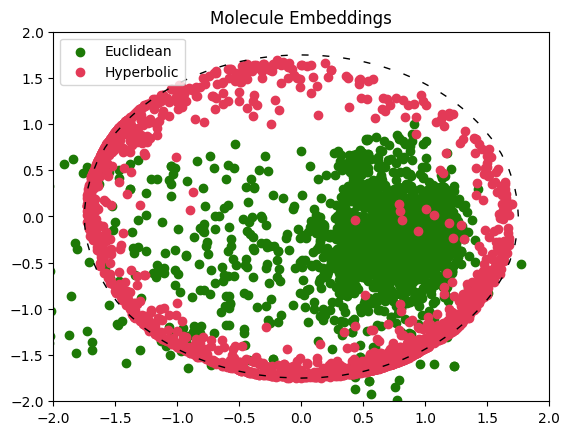

In [14]:
strawberry = '#E33A57'
# strawberry = '#CC3355'
bush = '#1D7906'
cyan = '#11DDDD'
green = '#11DD33'
lgreen = '#AFF091'

hyp_embs = torch.cat([embeddings[i][-1].T for i in range(FOLDS)], dim=1)
euc_embs = torch.cat([embeddings[FOLDS+i][-1].T for i in range(FOLDS)], dim=1)

fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()

# plt.scatter(*euc_embs[:,::5], c=bush)
ax.scatter(*euc_embs, c=bush)

# plt.scatter(*hyp_embs[:,::5], c=strawberry)
ax.scatter(*hyp_embs, c=strawberry)

t = np.arange(0,2*np.pi,0.1)
plt.plot(1.75*np.cos(t), 1.75*np.sin(t), linewidth=1, linestyle=(0, (5,10)), c='black')

ax.set_title(f'{DATASET} Embeddings')

ax.legend(['Euclidean', 'Hyperbolic'], loc='upper left')

# lim = torch.cat([embeddings[i][-1].T for i in range(2*FOLDS)]).abs().max().to(int)+1
lim = 2
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
# ax.set_zlim(-lim,lim)
# plt.savefig(f'embedding_plot_{DATASET}_zoomed.pdf')
plt.show()

In [15]:
hyp_midpoints = []
euc_midpoints = []

RANGE = 3
clip_val = 4
for i in range(RANGE):
    if i == RANGE - 1:
        hyp_midpoints.append(np.array(hyp_embs[:,train_y.sum(axis=1) >= i].clip(-clip_val,clip_val).mean(axis=1)))
        euc_midpoints.append(np.array(euc_embs[:,train_y.sum(axis=1) >= i].clip(-clip_val,clip_val).mean(axis=1)))
    else:
        hyp_midpoints.append(np.array(hyp_embs[:,train_y.sum(axis=1) == i].clip(-clip_val,clip_val).mean(axis=1)))
        euc_midpoints.append(np.array(euc_embs[:,train_y.sum(axis=1) == i].clip(-clip_val,clip_val).mean(axis=1)))

hyp_midpoints = np.array(hyp_midpoints).T
euc_midpoints = np.array(euc_midpoints).T

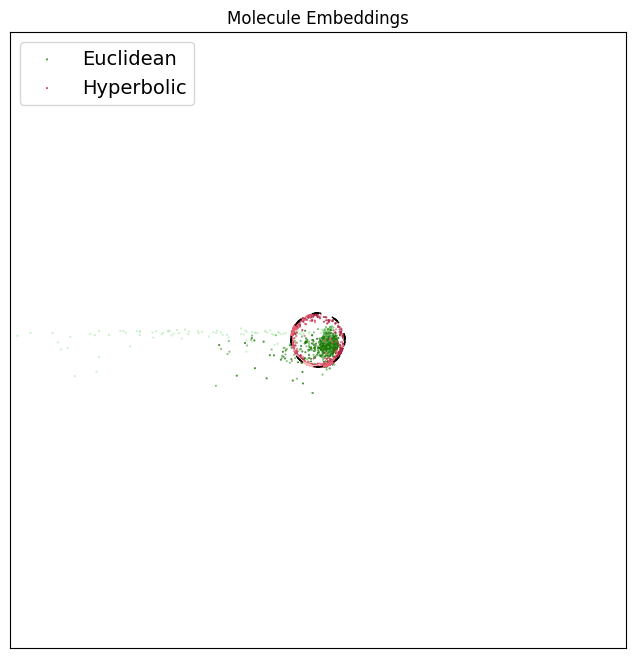

In [21]:
# pca = PCA(n_components=2)
# pca.fit(euc_embs.T)
# principal_component_0 = pca.components_[0]
# principal_component_1 = pca.components_[1]
# projected_data_0 = pca.transform(euc_embs.T)[:,0]
# projected_data_1 = pca.transform(euc_embs.T)[:,1]
# # projected_points = pca.inverse_transform(projected_data)
# projected_points_0 = np.outer(projected_data_0, principal_component_0) + pca.mean_
# projected_points_1 = np.outer(projected_data_1, principal_component_1) + pca.mean_
# ax.scatter(*projected_points_1.T, cmap=b_cmap, c=train_y.sum(axis=1).clip(0,RANGE-1))
# ax.scatter(*projected_points_0.T, cmap=b_cmap, c=train_y.sum(axis=1).clip(0,RANGE-1))


# pca = PCA(n_components=2)
# pca.fit(hyp_embs.T)
# principal_component_0 = pca.components_[0]
# principal_component_1 = pca.components_[1]
# projected_data_0 = pca.transform(hyp_embs.T)[:,0]
# projected_data_1 = pca.transform(hyp_embs.T)[:,1]
# # projected_points = pca.inverse_transform(projected_data)
# projected_points_0 = np.outer(projected_data_0, principal_component_0) + pca.mean_
# projected_points_1 = np.outer(projected_data_1, principal_component_1) + pca.mean_
# ax.scatter(*projected_points_1.T, cmap=s_cmap, c=train_y.sum(axis=1).clip(0,RANGE-1))
# ax.scatter(*projected_points_0.T, cmap=s_cmap, c=train_y.sum(axis=1).clip(0,RANGE-1))

# plt.scatter(*euc_midpoints, c='b')
# plt.scatter(*hyp_midpoints, c='y')


# comb_min, comb_max = data[OVERALL_LIKING].min(), data[OVERALL_LIKING].max()
# norm = plt.Normalize(comb_min, comb_max)

strawberry = '#E33A57'
# strawberry = '#CC3355'
bush = '#1D7906'

s_colors = [(0, '#FFBBBB'), (0.7, '#E33A57'), (1, '#AF2443')]
b_colors = [(0, '#BBEEBB'), (1, bush)]
s_cmap = LinearSegmentedColormap.from_list('Diff', s_colors)
b_cmap = LinearSegmentedColormap.from_list('Diff', b_colors)


step = 2
scale = 10
size = 2/scale
offset = 1

hyp_embs = np.array(torch.cat([embeddings[i][-1].T for i in range(FOLDS)], dim=1))
euc_embs = np.array(torch.cat([embeddings[FOLDS+i][-1].T for i in range(FOLDS)], dim=1))


c_vals = train_y.sum(axis=1).clip(0,RANGE-1)
sorted_c_idx = np.argsort(c_vals)[::-1]
sorted_c_vals = c_vals[sorted_c_idx]

sorted_hyp_embs = hyp_embs[:,sorted_c_idx]
sorted_euc_embs = euc_embs[:,sorted_c_idx]

num_move_vals = 20
idx = np.arange(len(sorted_c_vals))
# Get every 10th entry
every_10th_entry = idx[num_move_vals-1::num_move_vals]

# Get the remaining entries
remaining_idx = np.delete(idx, np.arange(num_move_vals-1, len(idx), num_move_vals))

# Concatenate every 10th entry at the front of the remaining entries
move_idx = np.concatenate((every_10th_entry, remaining_idx))
# print(move_idx)
sorted_c_vals = sorted_c_vals[move_idx]
sorted_hyp_embs = sorted_hyp_embs[:, move_idx]
sorted_euc_embs = sorted_euc_embs[:, move_idx]

fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()

ax.scatter(*euc_embs[:,::step], cmap=b_cmap, c=c_vals[::step], s=size)
# ax.scatter(*sorted_euc_embs[:,::step], cmap=b_cmap, c=sorted_c_vals[::step], s=size)


ax.scatter(*sorted_hyp_embs[:,::step], cmap=s_cmap, c=sorted_c_vals[::step], s=size)

t = np.arange(0,4*np.pi,0.1)
plt.plot(1.75*np.cos(t), 1.75*np.sin(t), linewidth=1, linestyle=(0, (5,10)), c='black')

ax.set_title(f'{DATASET} Embeddings')

ax.legend(['Euclidean', 'Hyperbolic'], loc='upper left', fontsize=14)

# lim = torch.cat([embeddings[i][-1].T for i in range(2*FOLDS)]).abs().max().to(int)+1
lim = 2*scale
ax.set_xlim(-lim,lim*offset)
ax.set_ylim(-lim,lim*offset)
# plt.savefig(f'embedding_plot_{DATASET}_zoomed_out_small.pdf')
# plt.savefig(f'embedding_plot_{DATASET}.pdf')

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

plt.show()

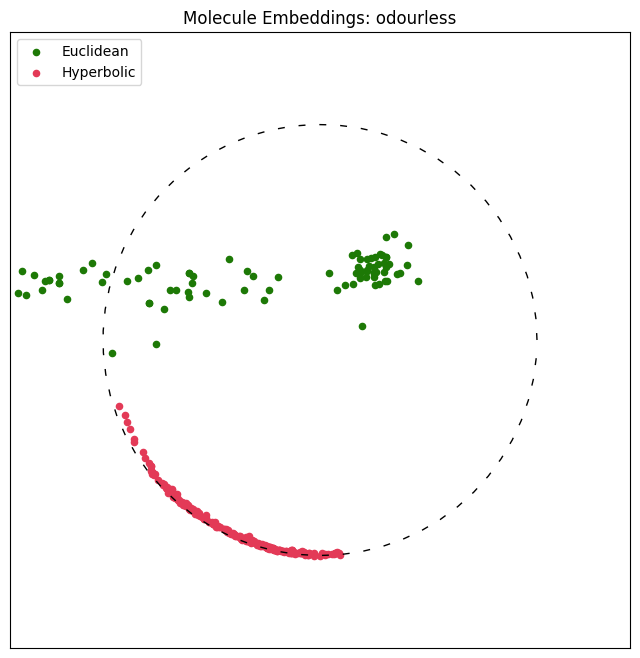

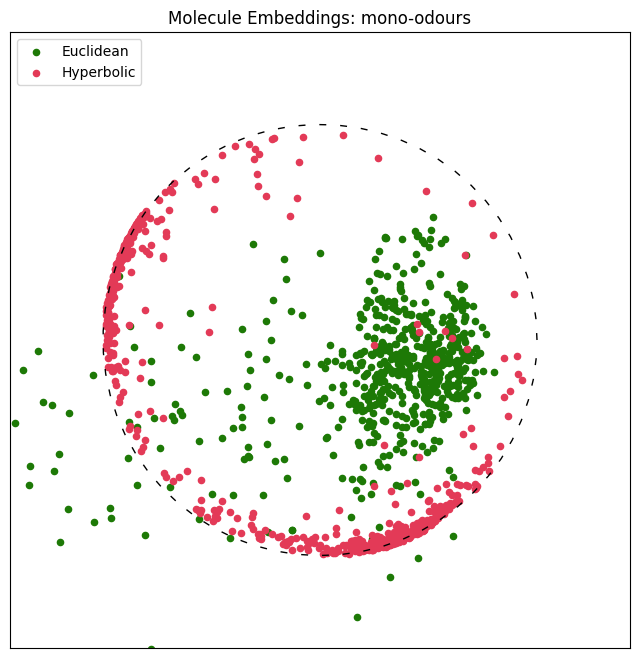

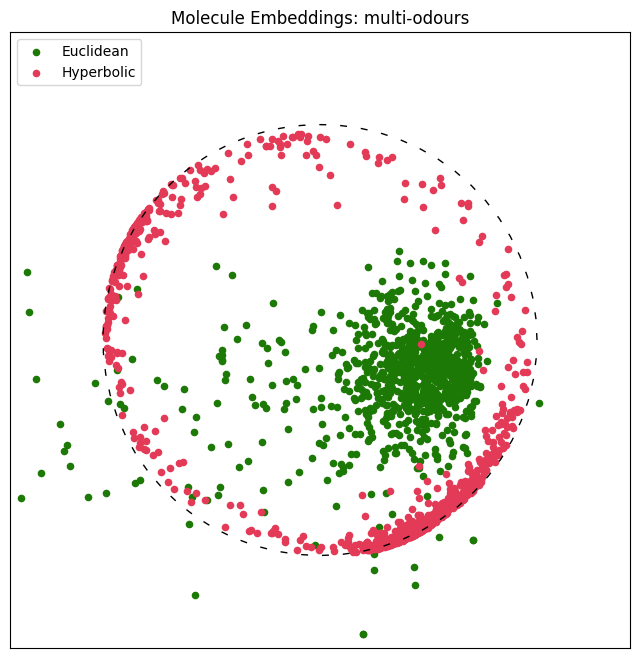

In [18]:
s_colors = [(0, '#FFBBBB'), (1, strawberry)]
b_colors = [(0, '#BBEEBB'), (1, bush)]
s_cmap = LinearSegmentedColormap.from_list('Diff', s_colors)
b_cmap = LinearSegmentedColormap.from_list('Diff', b_colors)

size = 20

hyp_embs = np.array(torch.cat([embeddings[i][-1].T for i in range(FOLDS)], dim=1))
euc_embs = np.array(torch.cat([embeddings[FOLDS+i][-1].T for i in range(FOLDS)], dim=1))

for i, name in enumerate(['odourless', 'mono-odours', 'multi-odours']):
    fig = plt.figure(figsize=(8,8))
    # ax = fig.add_subplot(projection='3d')
    ax = fig.add_subplot()

    plt.scatter(*euc_embs[:,train_y.sum(axis=1) == i], c=bush, s=size)

    plt.scatter(*hyp_embs[:,train_y.sum(axis=1) == i], c=strawberry, s=size)

    t = np.arange(0,2*np.pi,0.1)
    plt.plot(1.75*np.cos(t), 1.75*np.sin(t), linewidth=1, linestyle=(0, (5,10)), c='black')

    ax.set_title(f'{DATASET} Embeddings: {name}')

    ax.legend(['Euclidean', 'Hyperbolic'], loc='upper left')

    # lim = torch.cat([embeddings[i][-1].T for i in range(2*FOLDS)]).abs().max().to(int)+1
    lim = 2.5
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    # ax.set_zlim(-lim,lim)
    # plt.savefig(f'embedding_plot_{DATASET}_zoomed.pdf')

    ax.set_xticks([])
    ax.set_yticks([])

    # ax.set_aspect('equal')

    plt.show()

In [231]:
train_idx = train_indices.flatten()
train_idx

array([   0,    1,    2, ..., 2563, 2564, 2565])

In [232]:
# # [1491, 1282, 2295, 2267, 1967, 1732, 2101, 1260, 1330, 2228]
# center_mols = (hyp_embs**2).sum(axis=0).argsort()[:20]

# with open('../molecule_based/old_stuff/compounds.json', 'r') as file:
#     string_compounds = json.load(file)
#     compounds = {int(k): v for k, v in string_compounds.items()}
#     del string_compounds
# compounds = compounds

# mol_weights = {mol_id: float(compounds[mol_id]['molecular_weight']) for mol_id in data.index}

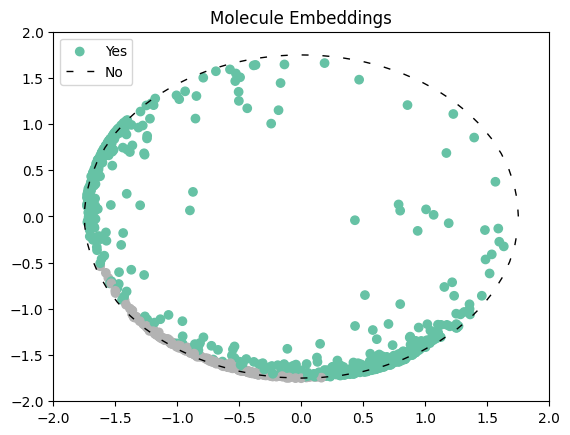

In [234]:
strawberry = '#E33A57'
bush = '#1D7906'
cyan = '#11DDDD'
green = '#11DD33'
lgreen = '#AFF091'

# colors = [(0, '#11DDDD'), (0.5, ('#EEEEEE')), (1, '#11DD33')] #for strawberry
# colors = [(0, strawberry), (1, bush)]
# cmap = LinearSegmentedColormap.from_list('Diff', colors)

cmap = 'Set2'

# c = [mol_weights[id] for id in data.index[train_idx]]
# c = (train_y[:,[0,1]].sum(axis=1)).astype(bool)
c = 1 - (train_y.sum(axis=1)).astype(bool)
# c = train_y.argmax(axis=1)

hyp_embs = torch.cat([embeddings[i][-1].T for i in range(FOLDS)], dim=1).T
euc_embs = torch.cat([embeddings[FOLDS+i][-1].T for i in range(FOLDS)], dim=1).T

# plt.scatter(*hyp_embs.T, c=strawberry)
# plt.scatter(*hyp_embs[::10].T, cmap=cmap, c=c[::10])
plt.scatter(*hyp_embs[(train_y.sum(axis=1) <= 1)].T, cmap=cmap, c=c[(train_y.sum(axis=1) <= 1)])
# plt.scatter(*hyp_embs[center_mols].T, cmap=cmap, c=c[center_mols])

# plt.scatter(*euc_embs.T, cmap=cmap, c=c)


t = np.arange(0,2*np.pi,0.1)
plt.plot(1.75*np.cos(t), 1.75*np.sin(t), linewidth=1, linestyle=(0, (5,10)), c='black')

plt.title(f'{DATASET} Embeddings')

plt.legend(['Yes', 'No'], loc='upper left')

# lim = torch.cat([embeddings[i][-1].T for i in range(2*FOLDS)]).abs().max().to(int)+1
lim = 2
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.show()

In [55]:
train_y[(train_y.sum(axis=1) <= 1)].shape

(890, 12)

In [56]:
hyp_embs.shape

torch.Size([2, 2566])

In [ ]:
train_y.sum(axis=1).min()

1